In [15]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans

In [16]:
df = pd.read_excel("Updated file AQI.xlsx")

In [17]:
df.head()

,measure,State,sex,age,cause,year,Deaths,AQI,Number of Hospitals2,Number of Beds2,NO2,SO2,PM10,PM2.5
0,Deaths,Uttar Pradesh,Male,15-19 years,Asthma,2015,72.466215,179.594079,831,54965,28.566038,10.679245,181.716981,96.8
1,Deaths,Uttar Pradesh,Female,15-19 years,Asthma,2015,110.270358,179.594079,831,54965,28.566038,10.679245,181.716981,96.8
2,Deaths,Uttar Pradesh,Male,20-24 years,Asthma,2015,112.532770,179.594079,831,54965,28.566038,10.679245,181.716981,96.8
3,Deaths,Uttar Pradesh,Female,20-24 years,Asthma,2015,133.389949,179.594079,831,54965,28.566038,10.679245,181.716981,96.8
4,Deaths,Uttar Pradesh,Male,30-34 years,Asthma,2015,235.578511,179.594079,831,54965,28.566038,10.679245,181.716981,96.8


In [18]:
# Handling missing values with median imputation
pollution_columns = ["NO2", "SO2", "PM10"]
df[pollution_columns] = df[pollution_columns].fillna(df[pollution_columns].median())

In [19]:
features = ["AQI", "NO2", "SO2", "PM10", "PM2.5"]

In [20]:
# Standardizing the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[features])

In [21]:
# PCA for HSI calculation
pca = PCA(n_components=1)
pca_index = pca.fit_transform(scaled_features)
df["HSI_PCA"] = (pca_index - pca_index.min()) / (pca_index.max() - pca_index.min())

In [22]:
# Regression Analysis for HSI
X = df[features]
y = df["Deaths"]

In [23]:
regression_model = LinearRegression()
regression_model.fit(X, y)
regression_index = regression_model.predict(X)
df["HSI_Regression"] = (regression_index - regression_index.min()) / (regression_index.max() - regression_index.min())

In [24]:
# Final HSI Calculation (average of PCA & Regression)
df["HSI_Final"] = (df["HSI_PCA"] + df["HSI_Regression"]) / 2

In [25]:
# Aggregating HSI at state level
state_hsi = df.groupby("State")["HSI_Final"].mean().reset_index()
state_hsi

,State,HSI_Final
0,Andhra Pradesh,0.222790
1,Assam,0.273151
2,Bihar,0.653452
3,Chhattisgarh,0.271454
4,Delhi,0.833614
5,Gujarat,0.410343
6,Haryana,0.475734
7,Jharkhand,0.494919
8,Karnataka,0.194594
9,Kerala,0.129679


## Heirarchal clustering

In [27]:
# Scaling HSI for Clustering
scaler = StandardScaler()
state_hsi_scaled = scaler.fit_transform(state_hsi[["HSI_Final"]])


In [29]:
import pandas as pd
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

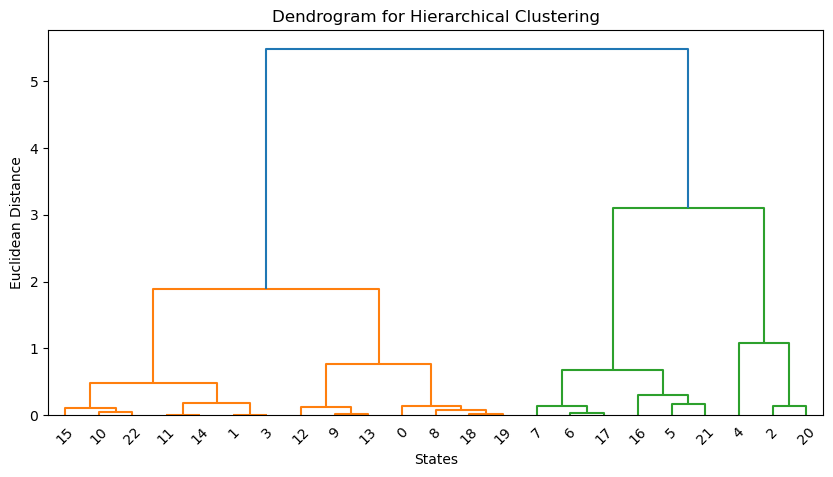

In [30]:
# Dendrogram for Hierarchical Clustering
plt.figure(figsize=(10, 5))
dendrogram = sch.dendrogram(sch.linkage(state_hsi_scaled, method='ward'))
plt.title("Dendrogram for Hierarchical Clustering")
plt.xlabel("States")
plt.ylabel("Euclidean Distance")
plt.show()

In [31]:
# Applying Agglomerative Clustering
num_clusters = 3  # Change as needed based on dendrogram
hc = AgglomerativeClustering(n_clusters=num_clusters, affinity='euclidean', linkage='ward')
state_hsi["Cluster"] = hc.fit_predict(state_hsi_scaled)


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [33]:
from IPython.display import display

# Display the DataFrame in a table format (better for Jupyter)
display(state_hsi)


,State,HSI_Final,Cluster
0,Andhra Pradesh,0.222790,0
1,Assam,0.273151,0
2,Bihar,0.653452,1
3,Chhattisgarh,0.271454,0
4,Delhi,0.833614,1
5,Gujarat,0.410343,2
6,Haryana,0.475734,2
7,Jharkhand,0.494919,2
8,Karnataka,0.194594,0
9,Kerala,0.129679,0


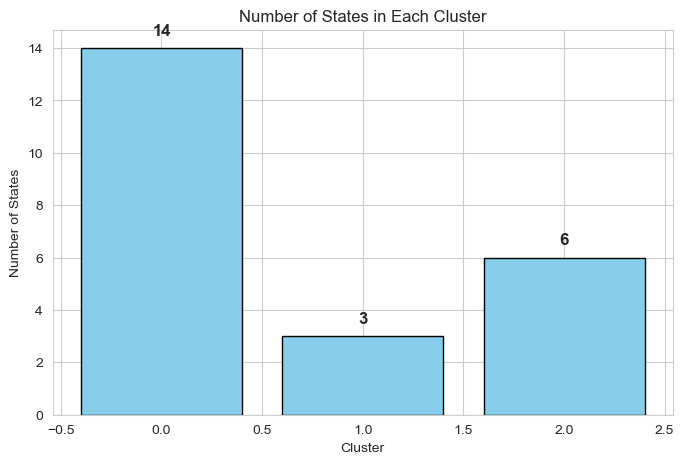

In [38]:
import matplotlib.pyplot as plt

# Count number of states in each cluster
cluster_counts = state_hsi["Cluster"].value_counts().sort_index()

# Plot
plt.figure(figsize=(8, 5))
plt.bar(cluster_counts.index, cluster_counts.values, color="skyblue", edgecolor="black")

# Add count labels on top of each bar
for i, count in enumerate(cluster_counts.values):
    plt.text(cluster_counts.index[i], count + 0.5, str(count), ha="center", fontsize=12, fontweight="bold")

# Labels and title
plt.xlabel("Cluster")
plt.ylabel("Number of States")
plt.title("Number of States in Each Cluster")

# Show plot
plt.show()


In [39]:
# Mapping clusters to risk levels
risk_labels = {0: "Low Risk", 1: "Moderate Risk", 2: "High Risk"}
state_hsi["Risk Category"] = state_hsi["Cluster"].map(risk_labels)

In [40]:
new_df=state_hsi['Risk Category'].value_counts()

In [41]:
new_df.reset_index()
new_df.columns=['Risk_Category','count']
new_df.columns

['Risk_Category', 'count']

In [45]:
# Merge cluster labels back into the main dataset
df = df.merge(state_hsi[["State", "Cluster"]], on="State", how="left")
df

,measure,State,sex,age,cause,year,Deaths,AQI,Number of Hospitals2,Number of Beds2,NO2,SO2,PM10,PM2.5,HSI_PCA,HSI_Regression,HSI_Final,Cluster
0,Deaths,Uttar Pradesh,Male,15-19 years,Asthma,2015,72.466215,179.594079,831,54965,28.566038,10.679245,181.716981,96.8,0.571768,0.696948,0.634358,1
1,Deaths,Uttar Pradesh,Female,15-19 years,Asthma,2015,110.270358,179.594079,831,54965,28.566038,10.679245,181.716981,96.8,0.571768,0.696948,0.634358,1
2,Deaths,Uttar Pradesh,Male,20-24 years,Asthma,2015,112.532770,179.594079,831,54965,28.566038,10.679245,181.716981,96.8,0.571768,0.696948,0.634358,1
3,Deaths,Uttar Pradesh,Female,20-24 years,Asthma,2015,133.389949,179.594079,831,54965,28.566038,10.679245,181.716981,96.8,0.571768,0.696948,0.634358,1
4,Deaths,Uttar Pradesh,Male,30-34 years,Asthma,2015,235.578511,179.594079,831,54965,28.566038,10.679245,181.716981,96.8,0.571768,0.696948,0.634358,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34449,Deaths,West Bengal,Female,25+ years,Asthma,2021,5910.553090,117.824000,1594,96012,27.032143,12.307857,117.406429,42.5,0.355594,0.375746,0.365670,0
34450,Deaths,West Bengal,Male,85+ years,Asthma,2021,491.374056,117.824000,1594,96012,27.032143,12.307857,117.406429,42.5,0.355594,0.375746,0.365670,0
34451,Deaths,West Bengal,Female,85+ years,Asthma,2021,863.629863,117.824000,1594,96012,27.032143,12.307857,117.406429,42.5,0.355594,0.375746,0.365670,0
34452,Deaths,West Bengal,Male,75-84 years,Asthma,2021,1255.361911,117.824000,1594,96012,27.032143,12.307857,117.406429,42.5,0.355594,0.375746,0.365670,0


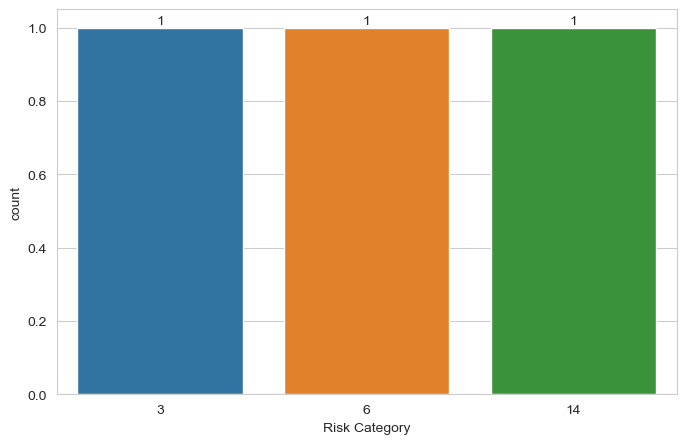

In [47]:
# Count occurrences of each Risk Category
temp = temp["Risk Category"].value_counts().reset_index()
temp.columns = ["Risk Category", "count"]  # Rename columns properly

# Create the bar plot
plt.figure(figsize=(8, 5))
ax = sns.barplot(x="Risk Category", y="count", data=temp)

# Add count labels on top of each bar
for bars in ax.containers:
    ax.bar_label(bars)

In [46]:
# Save the output
df.to_csv("HSI_Results.csv", index=False)
state_hsi.to_csv("State_HSI_Clusters_Heirachal.csv", index=False)

print("HSI calculation and clustering completed. Results saved as CSV files.")

HSI calculation and clustering completed. Results saved as CSV files.
